<a href="https://colab.research.google.com/github/juliasliu/info159/blob/main/HW3/HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3: Pytorch and CNNs

In this homework, you will begin exploring Pytorch, a neural network library that will be used throughout the remainder of the semester.  This homework will focus on implementing a bag-of-words logistic regression and a convolutional neural networks.



In [120]:
import numpy as np
import nltk
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import nltk
from collections import Counter

#Sets random seeds for reproducibility
seed=159259
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [121]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


When looking up pytorch documentation, it may be useful to know which version of torch you are running.


In [122]:
print(torch.__version__)

1.10.0+cu111


# **IMPORTANT**: GPU is not enabled by default

You must switch runtime environments if your output of the next block of code has an error saying "ValueError: Expected a cuda device, but got: cpu"

Go to Runtime > Change runtime type > Hardware accelerator > GPU

In [123]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on {}".format(device))

Running on cuda


# Data Processing

Let's begin by loading our datasets and the 50-dimensional GLoVE word embeddings.  

In [124]:
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW3/train.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW3/dev.txt
!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW3/glove.6B.50d.50K.txt

--2022-02-10 07:47:30--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW3/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645801 (6.3M) [text/plain]
Saving to: ‘train.txt.4’

train.txt.4         100%[===================>]   6.34M  --.-KB/s    in 0.08s   

2022-02-10 07:47:30 (78.0 MB/s) - ‘train.txt.4’ saved [6645801/6645801]

--2022-02-10 07:47:30--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW3/dev.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1309909 (1.2M) [text/plain]
Saving to: ‘dev.txt.4’

In [125]:
trainingFile = "train.txt"
devFile = "dev.txt"

In [126]:
labels = {'pos': 0, 'neg': 1}

In [127]:
def get_batches(x, y, xType, batch_size=12):
    batches_x=[]
    batches_y=[]
    for i in range(0, len(x), batch_size):
        batches_x.append(xType(x[i:i+batch_size]))
        batches_y.append(torch.LongTensor(y[i:i+batch_size]))
    
    return batches_x, batches_y
        

In [128]:
PAD_INDEX = 0             # reserved for padding words
UNKNOWN_INDEX = 1         # reserved for unknown words
SEP_INDEX = 2

data_lens = []

def read_embeddings(filename, vocab_size=50000):
  """
  Utility function, loads in the `vocab_size` most common embeddings from `filename`
  
  Arguments:
  - filename:     path to file
                  automatically infers correct embedding dimension from filename
  - vocab_size:   maximum number of embeddings to load

  Returns 
  - embeddings:   torch.FloatTensor matrix of size (vocab_size x word_embedding_dim)
  - vocab:        dictionary mapping word (str) to index (int) in embedding matrix
  """

  # get the embedding size from the first embedding
  with open(filename, encoding="utf-8") as file:
    word_embedding_dim = len(file.readline().split(" ")) - 1

  vocab = {}

  embeddings = np.zeros((vocab_size, word_embedding_dim))
  with open(filename, encoding="utf-8") as file:
    for idx, line in enumerate(file):

      if idx + 2 >= vocab_size:
        break

      cols = line.rstrip().split(" ")
      val = np.array(cols[1:])
      word = cols[0]
      embeddings[idx + 2] = val
      vocab[word] = idx + 2
  
  # a FloatTensor is a multidimensional matrix
  # that contains 32-bit floats in every entry
  # https://pytorch.org/docs/stable/tensors.html
  return torch.FloatTensor(embeddings), vocab

# Logistic regression

First, let's code up logistic regression in pytorch so you can see how the general framework works, and also get a sense of its performance that we can compare a CNN against.

In [129]:
class LogisticRegressionClassifier(nn.Module):

   def __init__(self, input_dim, output_dim):
      super().__init__()
      self.linear = torch.nn.Linear(input_dim, output_dim)
 
    
   def forward(self, input): 
      x1 = self.linear(input)
      return x1

   def evaluate(self, x, y):

      self.eval()
      corr = 0.
      total = 0.
      with torch.no_grad():
        for x, y in zip(x, y):
          x, y = x.to(device), y.to(device)
          y_preds=self.forward(x)
          for idx, y_pred in enumerate(y_preds):
              prediction=torch.argmax(y_pred)
              if prediction == y[idx]:
                corr += 1.
              total+=1                          
      return corr/total


## Example: Average Embedding Representation
Let's train a logistic regression classifier where the input is the average GLoVE embedding for all words in a review.

In [130]:
def read_glove_data(filename, vocab, embs):
    data=[]
    data_labels=[]
    with open(filename) as file:
        for line in file:
            avg_emb=np.zeros(50)
            cols=line.rstrip().split("\t")
            idd = cols[0]
            label = cols[1]
            review = cols[2]
            words=nltk.word_tokenize(review)
            avg_counter = 0.
            for word in words:
                word=word.lower()
                if word in glove_vocab:
                    avg_emb += embs[glove_vocab[word]].numpy()
                    avg_counter += 1.
            avg_emb /= avg_counter

            data.append(avg_emb)
            data_labels.append(labels[label])
    return data, data_labels 


In [131]:
embs, glove_vocab = read_embeddings("glove.6B.50d.50K.txt")
avg_train_x, avg_train_y=read_glove_data(trainingFile, glove_vocab, embs)
avg_dev_x, avg_dev_y=read_glove_data(devFile, glove_vocab, embs)

In [132]:
avg_trainX, avg_trainY=get_batches(avg_train_x, avg_train_y, xType=torch.FloatTensor)
avg_devX, avg_devY=get_batches(avg_dev_x, avg_dev_y, xType=torch.FloatTensor)

In [133]:
logreg=LogisticRegressionClassifier(50, len(labels)).to(device)
optimizer = torch.optim.Adam(logreg.parameters(), lr=0.001, weight_decay=1e-5)
losses = []
cross_entropy=nn.CrossEntropyLoss()

num_labels=len(labels)

patience=10
maxDevAccuracy=0
patienceCounter=0

for epoch in range(200):
    logreg.train()
    
    for x, y in zip(avg_trainX, avg_trainY):
        x, y = x.to(device), y.to(device)
        y_pred=logreg.forward(x)
        loss = cross_entropy(y_pred.view(-1, num_labels), y.view(-1))
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    dev_accuracy=logreg.evaluate(avg_devX, avg_devY)
    
    # check if the dev accuracy is the best seen so far
    if dev_accuracy > maxDevAccuracy:
        maxDevAccuracy=dev_accuracy
        patienceCounter=0
    
    patienceCounter+=1
    
    if epoch % 5 == 0:
        print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
    if patienceCounter >= patience:
        print("Stopping training; no improvement on dev data after %s epochs" % patience)
        break

Epoch 0, dev accuracy: 0.649
Epoch 5, dev accuracy: 0.684
Epoch 10, dev accuracy: 0.702
Epoch 15, dev accuracy: 0.723
Epoch 20, dev accuracy: 0.728
Epoch 25, dev accuracy: 0.734
Epoch 30, dev accuracy: 0.737
Epoch 35, dev accuracy: 0.737
Epoch 40, dev accuracy: 0.739
Stopping training; no improvement on dev data after 10 epochs


# Deliverable 1. BOW Representation
Your last homework used sklearn for logistic regression classification using a bag-of-words representation. Here you'll do the same thing, but in pytorch.  Fill in a bag-of-words implementation into read_bow_data() to see how the logistic classifier model works with this different featurization. 

In [134]:
# This function creates a unigram vocabulary from the most frequent 10K words in the training data
def get_vocab(filename, max_words=10000):
    unigram_counts=Counter()
    with open(filename) as file:    
        for line in file:
            cols=line.rstrip().split("\t")
            idd = cols[0]
            label = cols[1]
            review = cols[2]
            words=nltk.word_tokenize(review)

            for word in words:
                word=word.lower()
                unigram_counts[word]+=1

    vocab={}
    for k,v in unigram_counts.most_common(max_words):
        vocab[k]=len(vocab)
    return vocab
        

In [135]:
def read_bow_data(filename, vocab):
    data=[]
    data_labels=[]
    with open(filename) as file:
        for line in file:
            cols=line.rstrip().split("\t")
            idd = cols[0]
            label = cols[1]
            review = cols[2]
            bow=np.zeros(len(vocab))

            words=nltk.word_tokenize(review)
            for word in words:
                word=word.lower()
                if word in vocab:
                  bow[vocab[word]] = 1

            data.append(bow)

            data_labels.append(labels[label])
    return data, data_labels 


In [136]:
bow_vocab=get_vocab(trainingFile)
bow_train_x, bow_train_y=read_bow_data(trainingFile, bow_vocab)
bow_dev_x, bow_dev_y=read_bow_data(devFile, bow_vocab)

In [137]:
bow_trainX, bow_trainY=get_batches(bow_train_x, bow_train_y, xType=torch.FloatTensor)
bow_devX, bow_devY=get_batches(bow_dev_x, bow_dev_y, xType=torch.FloatTensor)

In [138]:
logreg=LogisticRegressionClassifier(len(bow_vocab), len(labels)).to(device)
optimizer = torch.optim.Adam(logreg.parameters(), lr=0.001, weight_decay=1e-5)
losses = []
cross_entropy=nn.CrossEntropyLoss()
best_dev_acc = 0.

num_labels=len(labels)

patience=10
patienceCounter=0

for epoch in range(200):
    for x, y in zip(bow_trainX, bow_trainY):
        x, y = x.to(device), y.to(device)
        y_pred=logreg.forward(x)
        loss = cross_entropy(y_pred.view(-1, num_labels), y.view(-1))
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    dev_accuracy=logreg.evaluate(bow_devX, bow_devY)
            
    if epoch % 5 == 0:
        print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))

    # check if the dev accuracy is the best seen so far; save the model if so
    if dev_accuracy > best_dev_acc:
      torch.save(logreg.state_dict(), 'best-bowmodel-parameters.pt')
      best_dev_acc = dev_accuracy
      patienceCounter=0

    patienceCounter+=1
    if patienceCounter >= patience:
        print("Stopping training; no improvement on dev data after %s epochs" % patience)
        break
    
logreg.load_state_dict(torch.load('best-bowmodel-parameters.pt'))
print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))    

Epoch 0, dev accuracy: 0.844
Epoch 5, dev accuracy: 0.870
Epoch 10, dev accuracy: 0.859
Stopping training; no improvement on dev data after 10 epochs

Best Performing Model achieves dev accuracy of : 0.870


# Deliverable 2. CNN 

Now let's create our CNN.

In [139]:
def read_data(filename, vocab, labels):
    """
    :param filename: the name of the file
    :return: list of tuple ([word index list], label)
    as input for the forward and backward function
    """    
    data = []
    data_labels = []
    file = open(filename)
    for line in file:
        cols = line.split("\t")
        idd = cols[0]
        label = cols[1]
        review = cols[2]
        w_int = []
        for w in nltk.word_tokenize(review.lower()):
            if w in vocab:
                w_int.append(vocab[w])
            else:
                w_int.append(UNKNOWN_INDEX)
        data_lens.append(len(w_int))
        if len(w_int) < 549:
            w_int.extend([PAD_INDEX] * (549 - len(w_int)))
        if len(w_int) < 550:
          data.append((w_int))
          data_labels.append(labels[label])
    file.close()
    return data, data_labels


In [140]:
embs, cnn_vocab = read_embeddings("glove.6B.50d.50K.txt")

In [141]:
cnn_train_x, cnn_train_y = read_data(trainingFile, cnn_vocab, labels)
cnn_dev_x, cnn_dev_y = read_data(devFile, cnn_vocab, labels)

In [142]:
cnn_trainX, cnn_trainY=get_batches(cnn_train_x, cnn_train_y, torch.LongTensor)
cnn_devX, cnn_devY=get_batches(cnn_dev_x, cnn_dev_y, torch.LongTensor)

In [143]:
class CNNClassifier(nn.Module):

   def __init__(self, params, pretrained_embeddings):
      super().__init__()
      self.seq_len = params["max_seq_len"]
      self.num_labels = params["label_length"]
      
      '''
      Initialize the following layers according to the hw spec
      '''
      self.embeddings = nn.Embedding.from_pretrained(pretrained_embeddings)

      len_of_embeddings = len(pretrained_embeddings[0])

      # convolution over 1 word
      self.conv_1 = nn.Conv1d(in_channels=len_of_embeddings, out_channels=50, kernel_size=1, stride=1)

      # convolution over 2 words    
      self.conv_2 = nn.Conv1d(in_channels=len_of_embeddings, out_channels=50, kernel_size=2, stride=1)
        
      # convolution over 3 words
      self.conv_3 = nn.Conv1d(in_channels=len_of_embeddings, out_channels=50, kernel_size=3, stride=1)

      self.fc = nn.Linear(in_features=50 * 3, out_features=self.num_labels)

    
   def forward(self, input): 
      #embeds the input sequences
      x0 = self.embeddings(input)
      #changes dimensions to be consistent with conv1d
      x0 = x0.permute(0, 2, 1)

      '''
      Create the hidden representations according to the hw spec
      '''

      # Apply the one-word convolution, tanh, and max pool
      x1 = self.conv_1(x0)
      x1 = torch.tanh(x1)
      x1 = torch.max(x1, dim=2)[0]

      # Apply the two-word convolution, tanh, and max pool
      x2 = self.conv_2(x0)
      x2 = torch.tanh(x2)
      x2 = torch.max(x2, dim=2)[0]

      # Apply the three-word convolution, tanh, and max pool
      x3 = self.conv_3(x0)
      x3 = torch.tanh(x3)
      x3 = torch.max(x3, dim=2)[0]

      # Concatenates the output of all 3 convolution layers
      combined = torch.cat((x1, x2, x3), dim=1)

      # Connects the combined output to the fully-connected layer
      out = self.fc(combined)
      return out.squeeze()


   def evaluate(self, x, y):
      
      self.eval()
      corr = 0.
      total = 0.

      with torch.no_grad():

        for x, y in zip(x, y):
          x, y = x.to(device), y.to(device)
          y_preds=self.forward(x)
          for idx, y_pred in enumerate(y_preds):
              prediction=torch.argmax(y_pred)
              if prediction == y[idx]:
                corr += 1.
              total+=1                          
      return corr/total


In [144]:
# Running this cell should take ~2 minutes.
embs, cnn_vocab = read_embeddings("glove.6B.50d.50K.txt")
cnnmodel = CNNClassifier(params={"max_seq_len": 549, "label_length": len(labels)}, pretrained_embeddings=embs).to(device)
optimizer = torch.optim.Adam(cnnmodel.parameters(), lr=0.001, weight_decay=1e-5)
losses = []
cross_entropy=nn.CrossEntropyLoss()

num_epochs=15
best_dev_acc = 0.
patience=10


for epoch in range(num_epochs):
    cnnmodel.train()

    for x, y in zip(cnn_trainX, cnn_trainY):
      x, y = x.to(device), y.to(device)
      y_pred = cnnmodel.forward(x)
      loss = cross_entropy(y_pred.view(-1, cnnmodel.num_labels), y.view(-1))
      losses.append(loss) 
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    dev_accuracy=cnnmodel.evaluate(cnn_devX, cnn_devY)
   
    # check if the dev accuracy is the best seen so far; save the model if so
    print("Epoch %s, dev accuracy: %.3f" % (epoch, dev_accuracy))
    if dev_accuracy > best_dev_acc:
      torch.save(cnnmodel.state_dict(), 'best-cnnmodel-parameters.pt')
      best_dev_acc = dev_accuracy
      patienceCounter=0
        
    patienceCounter+=1
    if patienceCounter >= patience:
        print("Stopping training; no improvement on dev data after %s epochs" % patience)
        break

    
cnnmodel.load_state_dict(torch.load('best-cnnmodel-parameters.pt'))
print("\nBest Performing Model achieves dev accuracy of : %.3f" % (best_dev_acc))


Epoch 0, dev accuracy: 0.773
Epoch 1, dev accuracy: 0.800
Epoch 2, dev accuracy: 0.806
Epoch 3, dev accuracy: 0.803
Epoch 4, dev accuracy: 0.807
Epoch 5, dev accuracy: 0.807
Epoch 6, dev accuracy: 0.810
Epoch 7, dev accuracy: 0.811
Epoch 8, dev accuracy: 0.811
Epoch 9, dev accuracy: 0.815
Epoch 10, dev accuracy: 0.815
Epoch 11, dev accuracy: 0.807
Epoch 12, dev accuracy: 0.804
Epoch 13, dev accuracy: 0.807
Epoch 14, dev accuracy: 0.795

Best Performing Model achieves dev accuracy of : 0.815


# Model Exploration

## CNN Loss Examination
To debug your model and ensure it is updating correctly, it may be helpful to visualize your training loss.  The following code plots loss over epoch.  This should decrease as the model trains and eventually converge.  If your training loss is not decreasing, you might not be initializing your model or creating your forward() pass correctly.

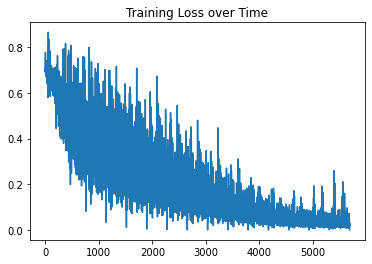

In [145]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)), losses)
plt.title("Training Loss over Time")
plt.show()

# Deliverable 3. BoW vs. CNN.

Compare and contrast the performance of your BoW representation and CNN. Did one model demonstrate a higher dev performance than the other? What do you see as the advantages of one model over the other that might lead to this performance difference on this data? Submit your <200 word answer to this question as a PDF on gradescope.

My CNN model (0.815) had a worse performance than the BoW representation (0.870). While BoW simply counts the frequency of each word in the file, CNN looks at words in groups or n-grams. Although the CNN model was expected to perform better since it accounted for the context of each word, because the words in this dataset were surrounded by other words with no similar meaning or context, the CNN performance ended up being worse than BoW. 